# Fine_tuning
- local에 있는 image들을 이용해 custom하게 DataSet object 생성

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms

import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

In [10]:
train_dir = './cats_and_dogs_small/train'
validation_dir = './cats_and_dogs_small/validation'
test_dir = './cats_and_dogs_small/test'

train_path = glob.glob(train_dir+'/*/*.jpg')
validation_path = glob.glob(validation_dir+'/*/*.jpg')
test_path = glob.glob(test_dir+'/*/*.jpg')

In [19]:
mapping = {'dogs':0,'cats':1}
train_df = pd.DataFrame()
train_df['path'] = train_path
train_df['target'] = train_df['path'].str.split('/').str[-2]
train_df['target'] = train_df['target'].replace(mapping)

validation_df = pd.DataFrame()
validation_df['path'] = validation_path
validation_df['target'] = validation_df['path'].str.split('/').str[-2]
validation_df['target'] = validation_df['target'].replace(mapping)


test_df = pd.DataFrame()
test_df['path'] = test_path
test_df['target'] = test_df['path'].str.split('/').str[-2]
test_df['target'] = test_df['target'].replace(mapping)


In [23]:
class FileDataSet(Dataset):
    def __init__(self, df, trsf=None):
        self.filepaths = df['path'].values
        self.targets = df['target'].values
        self.trsf = trsf
    def __len__(self):
        return len(self.filepaths)
    def __getitem__(self, idx):
        # read image as RGB format (original is BGR)
        image = plt.imread(self.filepaths[idx])
        if len(image.shape)==2:
            image = np.expand_dims(image, 2)
            image = np.stack([image,image,image],axis=2)
        if self.trsf:
            image = self.trsf(image)
        target = self.targets[idx]
        filepath = self.filepaths[idx]
        return filepath, image, target

In [33]:
img_size = 224
trsf_data = {
        'train': transforms.Compose([transforms.ToPILImage(),
            transforms.Resize((img_size, img_size)),
            transforms.RandomRotation(20),
            transforms.RandomAffine(0, translate=(0.2, 0.2)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()]),
        'val': transforms.Compose([transforms.ToPILImage(),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()])}

trainDS = FileDataSet(train_df, trsf_data['train'])
validDS = FileDataSet(validation_df, trsf_data['val'])
testDS = FileDataSet(test_df, trsf_data['val'])

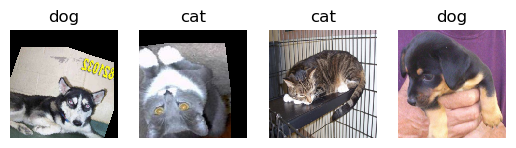

In [42]:
def plot_imges(k,num, mode):
    if mode=='train':
        _,temp_image, temp_target = trainDS[num]
    elif mode=='val':
        _,temp_image, temp_target = validDS[num]
    elif mode=='test':
        _,temp_image, temp_target = testDS[num]
    plt.subplot(1,4,k)
    plt.imshow(np.transpose(temp_image,(1,2,0)))
    plt.title('dog' if temp_target==0 else 'cat')
    plt.axis('off')

plot_imges(1,250,'train')
plot_imges(2,870,'train')
plot_imges(3,250,'val')
plot_imges(4,620,'val')

## pretrained model

In [88]:
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Using cache found in /home/choiyj/.cache/torch/hub/pytorch_vision_v0.10.0
/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [89]:
# freeze
for param in mobilenet.parameters():
    param.requires_grad = False

# replace the classifier
num_ftrs = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Linear(num_ftrs, 2,bias=True)

# parameters to update
params_to_update = []
for name,param in mobilenet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 classifier.1.weight
	 classifier.1.bias


## Train

In [90]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
batch_size = 64
epochs = 10
lr = 0.001
optimizer = torch.optim.Adam(params_to_update, lr=lr)

trainloader = DataLoader(trainDS, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = DataLoader(validDS, batch_size=batch_size, shuffle=False, num_workers=4)
testloader = DataLoader(testDS, batch_size=batch_size, shuffle=False, num_workers=4)

In [91]:
model = mobilenet.to(device)
criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(epochs):
    model.train()
    print(f'epoch : {epoch}')
    loss_tr = 0
    correct_tr = 0
    data_count_tr = 0
    for _,inputs,targets in trainloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_item = loss.item()
        loss_tr += loss_item*len(targets)
        _, predicted = torch.max(outputs.data, 1)
        correct_tr += (predicted == targets).sum().item()
        data_count_tr += targets.size(0)
    print(f'train loss: {loss_tr/data_count_tr}, train acc: {correct_tr/data_count_tr}')

    loss_val = 0
    correct_val = 0
    data_count_val = 0
    with torch.no_grad():
        model.eval()
        for _,inputs, targets in valloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss_item = loss.item()
            loss_val += loss_item*len(targets)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == targets).sum().item()
            data_count_val += targets.size(0)
    print(f'val loss: {loss_val/data_count_val}, val acc: {correct_val/data_count_val}')

        

epoch : 0
train loss: 0.4511695772409439, train acc: 0.785
val loss: 0.1841435217857361, val acc: 0.95375
epoch : 1
train loss: 0.29091666162014007, train acc: 0.889375
val loss: 0.13632698804140092, val acc: 0.95875
epoch : 2
train loss: 0.24595244288444518, train acc: 0.90125
val loss: 0.15182542830705642, val acc: 0.94
epoch : 3
train loss: 0.2450293004512787, train acc: 0.89375
val loss: 0.11755677595734597, val acc: 0.9575
epoch : 4
train loss: 0.2223093742132187, train acc: 0.909375
val loss: 0.107276823669672, val acc: 0.96125
epoch : 5
train loss: 0.20636978834867478, train acc: 0.909375
val loss: 0.10092897340655327, val acc: 0.96625
epoch : 6
train loss: 0.19823010861873627, train acc: 0.91875
val loss: 0.10003069803118705, val acc: 0.965
epoch : 7
train loss: 0.19224501878023148, train acc: 0.928125
val loss: 0.10189894303679466, val acc: 0.965
epoch : 8
train loss: 0.19361502170562744, train acc: 0.92
val loss: 0.09449599400162696, val acc: 0.9675
epoch : 9
train loss: 0.19

In [96]:
model.eval()
correct_test = 0
data_count_test = 0
for _, inputs,targets in testloader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    correct_test += (predicted == targets).sum().item()
    data_count_test += targets.size(0)
print(f'test acc : {correct_test/data_count_test}')

test acc : 0.95
